Notebook to summarize IOS Fall 2014 comparisons. Profile comaprisons condensed to a scatter plot.

In [1]:
import os
import glob

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime

import comparisons

from salishsea_tools import tidetools, viz_tools
from salishsea_tools.nowcast import analyze

import seaborn as sns

import ACTDR
import pandas as pd
%matplotlib inline

In [2]:
sns.set_color_codes()

In [3]:
nowcast_dir = '/results/SalishSea/nowcast/'
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')    
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
FIRST_NOWCAST = datetime.datetime(2014, 10,27)

In [15]:
def get_model_cast(year, month, day, lon, lat, field):
    """Get the model daily mean, max and min corresponding to given year, month, day and lat/lon"""
    
    if field =='Salinity':
        var = 'vosaline'
    elif field == 'Temperature':
        var = 'votemper'
        
    date = datetime.datetime(year, month, day)
    early_days = False
    if date < FIRST_NOWCAST:
        early_days = True
    #Look up grid point
    bathy, X, Y= tidetools.get_bathy_data(grid_B)
    j, i = tidetools.find_closest_model_point(lon, lat, X, Y, bathy)
    # Grab data
    depths = mesh.variables['gdept'][0,:,j,i]
    if early_days:
        var_model = comparisons.early_model_data(date, j, i, '1h', 'grid_T', var, nowcast_dir)
    else:
        results_dir = os.path.join(nowcast_dir, date.strftime('%d%b%y').lower())
        grid_T_h = comparisons.results_dataset('1h', 'grid_T', results_dir)
        var_model = grid_T_h.variables[var][:, :, j, i]
    var_model, tmask = mask_model(j, i, var_model)
    # Daily mean/min/max
    mean_daily = np.mean(var_model, axis=0)
    max_daily = np.max(var_model, axis=0)
    min_daily = np.min(var_model, axis=0)
 
    return mean_daily, max_daily, min_daily, depths, tmask

In [5]:
def mask_model(j, i, var_model):
    """Mask a model variable at a grid point"""
    
    tmask = np.abs(1-mesh.variables['tmask'][:, :, j, i])
    tmask = tmask + np.zeros(var_model.shape)
    var_masked = np.ma.array(var_model, mask=tmask)
    return var_masked, tmask[0,:]

In [17]:
def prepare_cast_comparison(dep_obs, var_obs, year, month, day, lon, lat, field):
    """Gather model and observed cast data for comparison"""
    
    # model data 
    mean_mod, max_mod, min_mod, dep_mod, tmask = get_model_cast(year, month, day, lon, lat, field)
    
    # interp observations
    interp_obs = comparisons.interpolate_depth(var_obs, dep_obs, dep_mod)
    interp_obs = np.ma.array(interp_obs, mask=tmask)
    
    return interp_obs, mean_mod, max_mod, min_mod, dep_mod

In [7]:
ACTDR.load_dat('SOG_2000.dat')

('> open ', 'SOG_2000.dat')
> load CTD_DAT
> load STANDARD_KEYS
('> close ', 'SOG_2000.dat')
> complete


In [8]:
data = pd.DataFrame(ACTDR.CTD_DAT)
data_fall = data[(data.Year>=2014) & (data.Month >=10)  ]

In [9]:
sns.set_context('talk')

In [10]:
def scatter_compare(data, field, cmin, cmax, ax, units):
    for dep_obs, var_obs, lon, lat, year, month, day in zip(data['Depth'],
                                                        data[field],
                                                        data['Longitude'],
                                                        data['Latitude'],
                                                        data['Year'],
                                                        data['Month'],
                                                        data['Day']):

        interp_obs, mean_mod, max_mod, min_mod, dep_mod = prepare_cast_comparison(dep_obs, var_obs,
                                                                                  year, month, day,
                                                                                  lon, lat, field)
        ax.errorbar(interp_obs, mean_mod, yerr=[mean_mod-min_mod,max_mod-mean_mod ], fmt='o',marker='', 
                     zorder=0, ecolor='gray',lw=1)
        sc = ax.scatter(interp_obs, mean_mod, marker='o', edgecolor='',c= dep_mod, 
                         norm=mcolors.LogNorm(), cmap='Spectral', vmin=0.5, vmax=300, s=50)
        ax.set_xlim([cmin, cmax])
        ax.set_ylim([cmin, cmax])
        ax.plot([cmin, cmax],[cmin, cmax], 'r-',zorder=0)
    cb = plt.colorbar(sc, ax=ax)
    ticks = [1, 10, 25, 50, 100, 200, 400]
    cb.set_ticks(ticks)
    cb.set_ticklabels(ticks)
    cb.set_label('Depth [m]')
    ax.set_xlabel('Observed {} [{}]'.format(field, units))
    ax.set_ylabel('Modelled {} [{}]'.format(field, units))

In [11]:
def compare_region(data, lon_min, lon_max, lat_min, lat_max, title, smin=18, smax=32, tmin=8, tmax=16):
    data_region  = comparisons.isolate_region(data,lon_min, lon_max, lat_min, lat_max)
    #map
    fig, ax = plt.subplots(1,1)
    data_region.plot(x='Longitude', y='Latitude', ax=ax, kind='scatter')
    viz_tools.plot_coastline(ax,grid_B, coords='map')
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])
    ax.set_title(title)
    #sal
    fig,ax = plt.subplots(1,1)
    field = 'Salinity'; 
    scatter_compare(data_region, field, smin,smax,ax,'psu')
    ax.set_title('{} - {}'.format(title, field))
    #temp
    fig,ax = plt.subplots(1,1)
    field = 'Temperature';
    scatter_compare(data_region, field, tmin,tmax,ax,'deg C')
    ax.set_title('{} - {}'.format(title, field))

## Strait of Georgia

/home/nsoontie/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/ma/core.py:4085: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


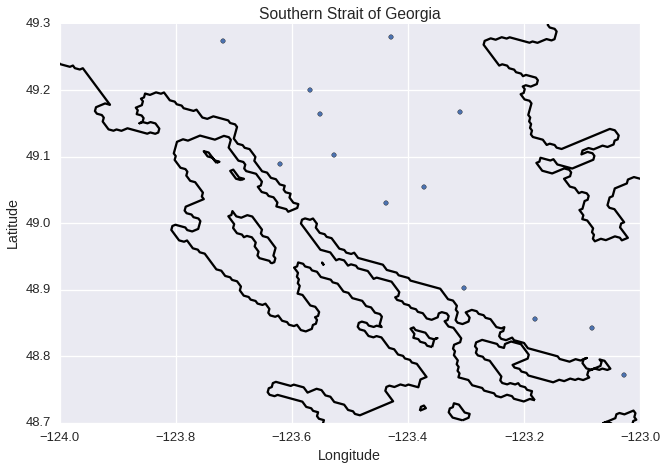

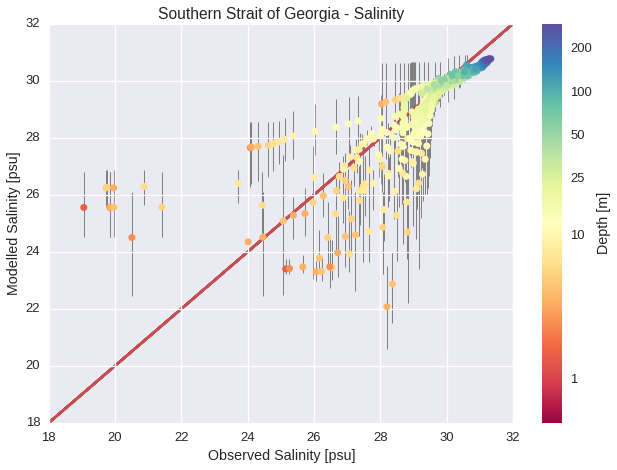

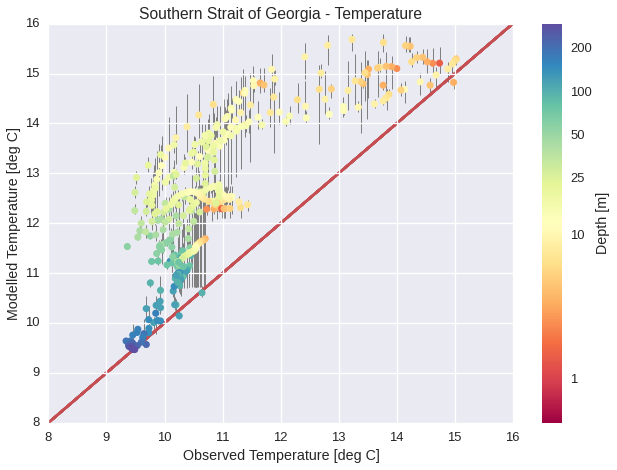

In [18]:
lon_min=-124
lon_max=-123
lat_min=48.7
lat_max=49.3
compare_region(data_fall, lon_min, lon_max, lat_min, lat_max, 'Southern Strait of Georgia')

## Northern SoG

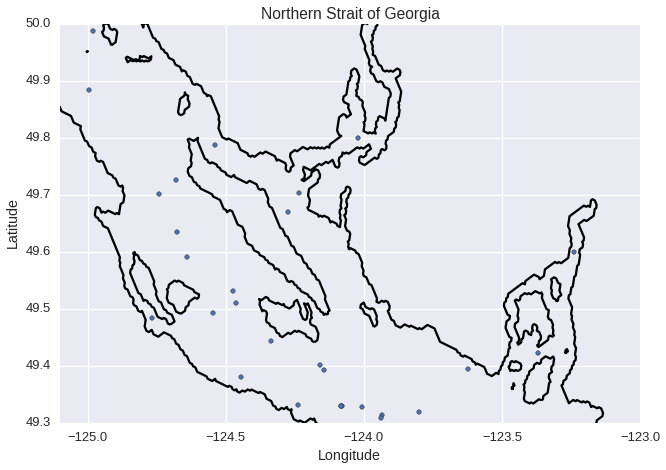

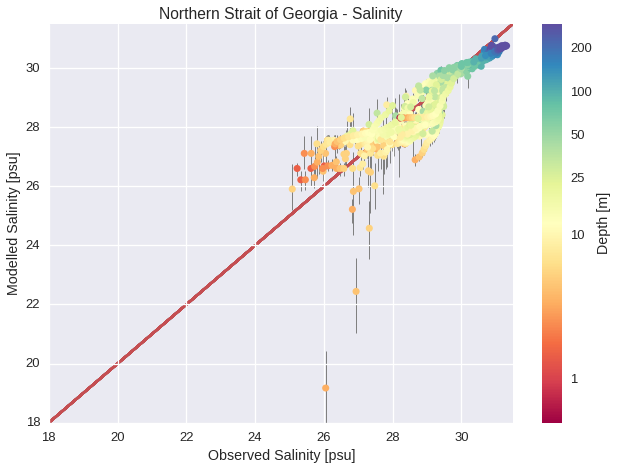

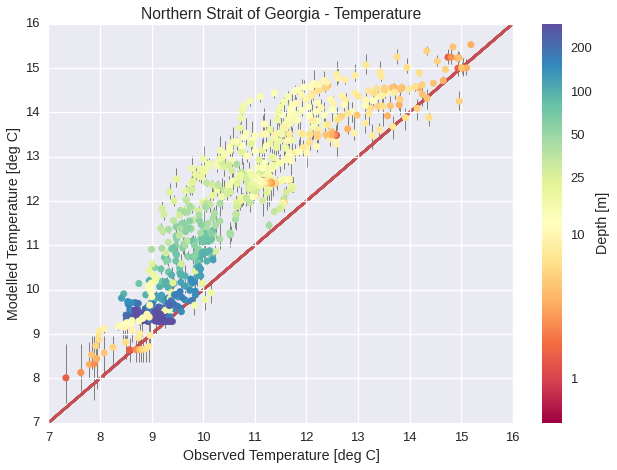

In [19]:
lon_min=-125.1
lon_max=-123
lat_min=49.3
lat_max=50
compare_region(data_fall, lon_min, lon_max, lat_min, lat_max, 'Northern Strait of Georgia',
               smin=18,smax=31.5, tmin=7, tmax=16,
               )

## Strait of Juan de Fuca

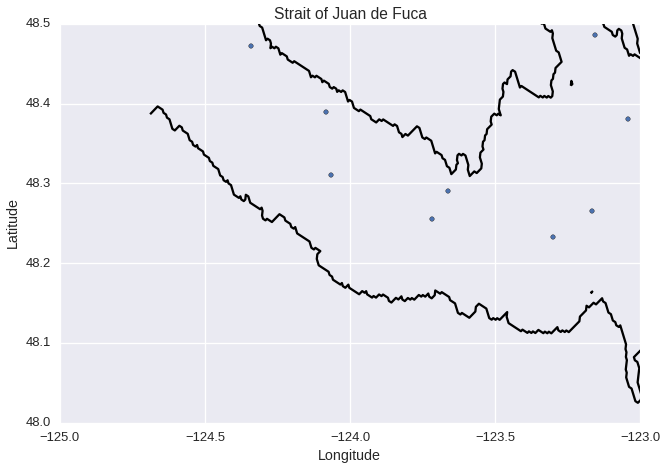

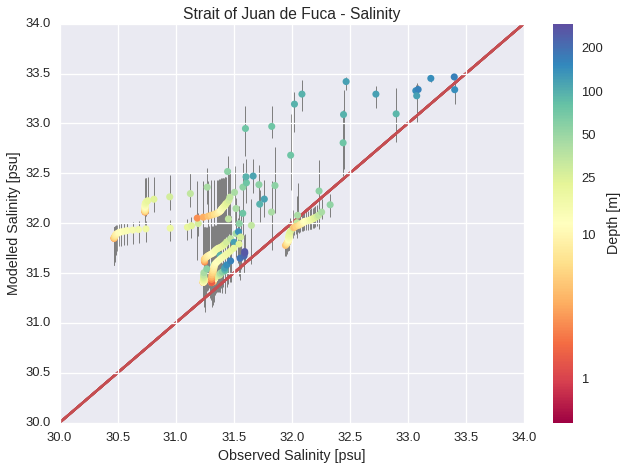

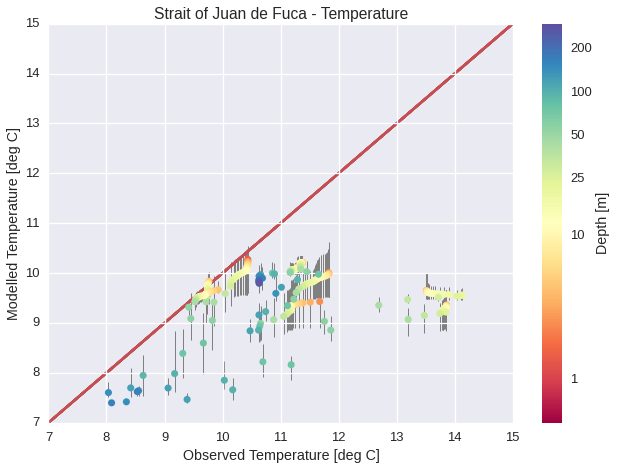

In [20]:
lon_min=-125
lon_max=-123
lat_min=48
lat_max=48.5
compare_region(data_fall, lon_min, lon_max, lat_min, lat_max, 'Strait of Juan de Fuca',
              smin=30,smax=34, tmin=7, tmax=15)

## Haro

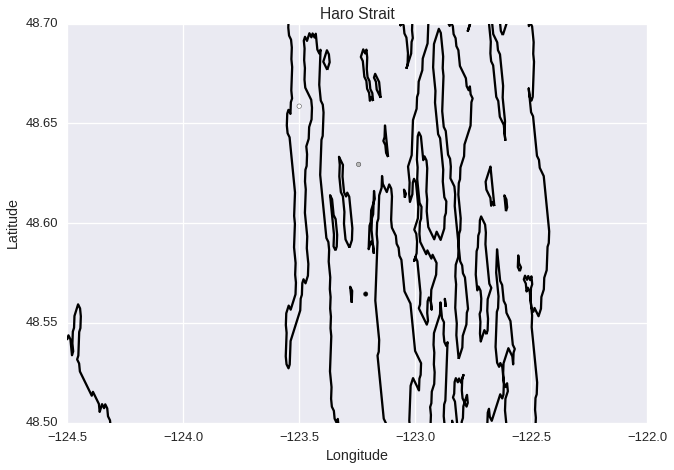

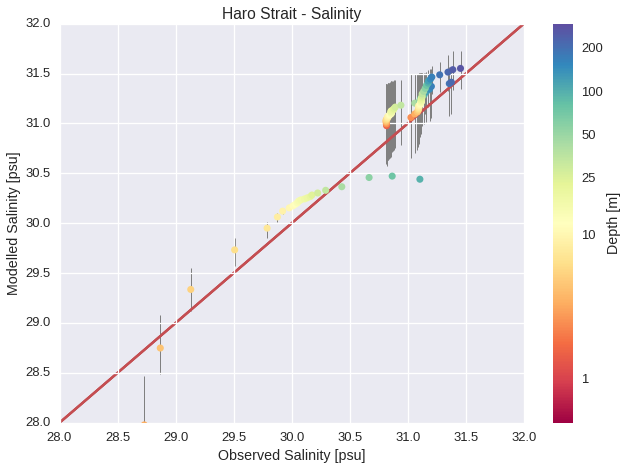

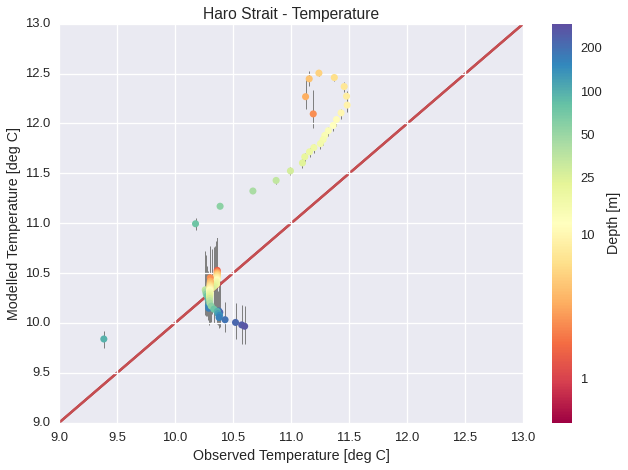

In [21]:
lon_min=-124.5
lon_max=-122
lat_min=48.5
lat_max=48.7
compare_region(data_fall, lon_min, lon_max, lat_min, lat_max, 'Haro Strait',
              smin=28,smax=32, tmin=9, tmax=13)